In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import polars as pl
from tqdm import tqdm 
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install torch~=2.3.0 torch_xla[tpu]~=2.3.0 -f https://storage.googleapis.com/libtpu-releases/index.html

# Setting parameters for training

In [7]:
# 读取数据
train_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv'
test_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv'
subm_spl = '/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv'
out_csv = 'submission.csv'

read_chunk_size = 100000 # 一次性读取100000行数据

# 训练参数
num_epochs = 50
max_patience = 3
batch_size = 360
num_workers = 256
lr = 0.0005

# 使用设备
tpu = True
if not tpu:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    device = 
# device = [cpu()] if num_gpus() == 0 else get_all_gpus()
device, tpu

('cpu', False)

# Timer for code running

Compute the time cost of a block

In [2]:
import time

class Timer:
    def __init__(self):
        self.t0 = 0
        self.t1 = 0
        self.times = []
        self.infos = []
        
    def start(self, info = 'Run'):
        self.t1 = self.t0
        self.infos.append(f'{len(self.infos)} {info}')
        self.t0 = time.time()
        
    def stop(self):
        self.t1 = time.time()
        t = self.t1 - self.t0
        self.times.append(t)
        print(f'{self.infos[-1]} Time Cost: {t:.3f}s')
        
    def get_stats(self):
        for info, tm in zip(self.infos, self.times):
            print(f'{info}\t{tm:.3f}s')
        print(f'Total: {sum(self.times):.3f} ')
    
    def clear(self, idx=0):
        if idx == 0:
            self.infos.clear()
            self.times.clear()
            return
        info = self.infos.pop(idx - (0 if idx < 0 else 1))
        tm = self.times.pop(idx - (0 if idx < 0 else 1))
        return info, tm
        
timer = Timer()

# File Paths and Chunk Size

- set file path for train set and test set
- read training dataset with chunks as its large file

- read data from csv file and get the 1st chunk

In [8]:
# 读取数据
timer.start(f'Read dataset chunk size {read_chunk_size}')
train_chunks = pd.read_csv(train_csv, chunksize = read_chunk_size)
train_data = next(train_chunks)
timer.stop()
# train_data = next(train_chunks)
# train_data = next(train_chunks)
cols = train_data.columns

train_data.shape

0 Read dataset chunk size 100000 Time Cost: 40.191s


(100000, 925)

# Split training set

1. split into input and output
2. split into 
    - training set
    - validation set
    - testing set

In [11]:
# 划分数据集

def split_io(dframe, in_cols = cols[1:557], out_cols = cols[557:]):
    # 划分输入输出
    in_df = dframe[in_cols]
    out_df = dframe[out_cols]
    return in_df, out_df

def split_tvt(dframe, ratio=[0.8], shuffle=False):
    # 设定好 train (和 val) 集的比例，剩余的均归到test/val
    assert sum(ratio) <= 1, "Ratio sum for train and val cannot be bigger than 1"
    assert len(ratio) > 0, "Ratio cannot be empty"
     # 根据是否需要测试集来调整比例
    train_rat = ratio[0]
    val_rat = (1 - train_rat) if len(ratio) == 1 else ratio[1]
    test_rat = (1 - train_rat - val_rat) if len(ratio) == 2 else 0
    
    data_size = dframe.shape[0]
    train_size = int(data_size * train_rat)
    val_size = (data_size - train_size) if len(ratio) == 1 else int(data_size * val_rat)
    
    if shuffle:
        dframe = dframe.sample(frac=1).reset_index(drop=True)
        
    train = dframe.iloc[:train_size]
    val = dframe.iloc[train_size:train_size + val_size]
    
    if test_rat != 0:
        test = dframe.iloc[train_size + val_size:]
        return train, val, test
    else:
        return train, val


In [12]:
# 划分数据集
train_set, val_set, test_set = split_tvt(train_data, [0.7, 0.2], True)
train_in, train_out = split_io(train_set)
val_in, val_out = split_io(val_set)
test_in, test_out = split_io(test_set)

print(f'{val_set.shape = }')
print(f'{test_set.shape = }')
print(f'{train_in.shape = }')
print(f'{train_out.shape = }')
print(f'{val_in.shape = }')
print(f'{val_out.shape = }')
print(f'{val_out.iloc[0] = }')

del(train_data)
del(train_set)
del(val_set)
del(test_set)

NameError: name 'train_data' is not defined

# Convert Data

Rearrange data with 60 dimensions into 2d tensor($n \times 60$) and data with 1 dimension into a 1d tensor($m \times 1$). 

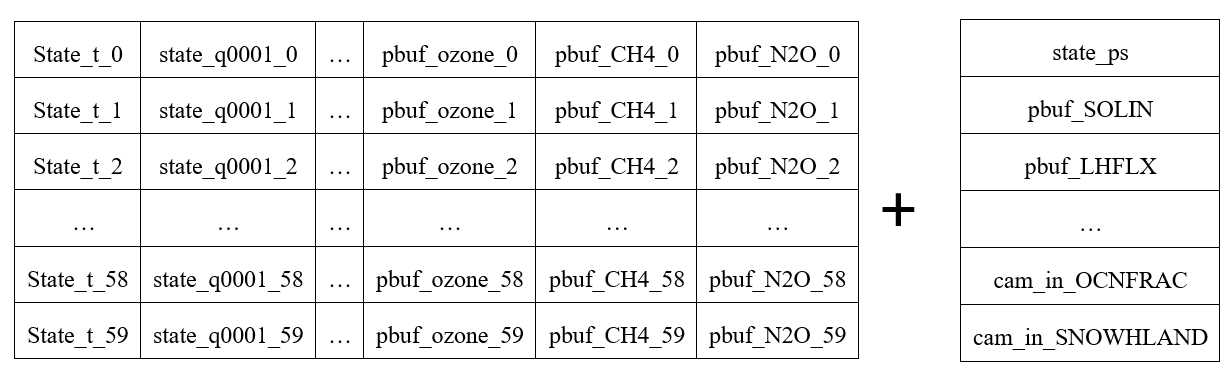  

<!-- <font color='red'>Un-comment images to see</font> -->

This is what input data look like

---

After test, the input has (16,1) and (9, 60), the output has (8,1) and (6, 60)

In [13]:
import re

# 转换数据集
def convert_data(cols, line):
    # 输入一个表头和一行的数据，将其转换为两个张量
    tensor1d = [[],[]]
    tensor2d = [[],[]]
    old_title = ''
    for col, value in zip(cols, line):
        match = re.search(r'_(\d+)$', col)
        if match is None: # in 1d tensor
            tensor1d[0].append(col)
            tensor1d[1].append([value])
        else:
            title = col[:-len(match.group(0))]
            if not title == old_title:
                old_title = title
                tensor2d[0].append(title)
                tensor2d[1].append([])
            tensor2d[1][-1].append(value)
    tensor1d[0] = np.array(tensor1d[0])
    tensor2d[0] = np.array(tensor2d[0])
    tensor1d[1] = np.array(tensor1d[1])
    tensor2d[1] = np.array(tensor2d[1])
    return tensor1d, tensor2d


In [14]:
d1, d2 = convert_data(val_out.columns, val_out.iloc[0]) # 测试一行
print(f'{d1[0].shape = }\t{d1[0].dtype = }')
print(f'{d1[1].shape = }\t{d1[1].dtype = }')
print(f'{d2[0].shape = }\t{d2[0].dtype = }')
print(f'{d2[1].shape = }\t{d2[1].dtype = }')
del(d1)
del(d2)

d1[0].shape = (8,)	d1[0].dtype = dtype('<U14')
d1[1].shape = (8, 1)	d1[1].dtype = dtype('float64')
d2[0].shape = (6,)	d2[0].dtype = dtype('<U11')
d2[1].shape = (6, 60)	d2[1].dtype = dtype('float64')


# Dataset

Define a custom dataset for this input/output

In [15]:
class MyDataset(Dataset):
    def __init__(self, dsin, dsout, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.dsout = dsout
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.iloc[x])
#         out1, out2 = convert_data(self.dsout.columns, self.dsout.iloc[x])
        din = [in1[1], in2[1]]
#         dout = [out1[1], out2[1]]
        dout = np.array([[value] for value in self.dsout.iloc[x]])
#         print(f'{dout.shape = }')
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
#             dout[0] = self.transform(dout[0])
#             dout[1] = self.transform(dout[1])
            dout = self.transform(dout)
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
#         dout = [torch.from_numpy(tensor) for tensor in dout]
        din = [tensor.to(torch.float32) for tensor in din]
#         dout = [tensor.to(torch.float32)  for tensor in dout]
        dout = dout.to(torch.float32)
        
        return din, dout

In [16]:
def cpu():  
    return torch.device('cpu')

def gpu(i=0): 
    return torch.device(f'cuda:{i}')

def num_gpus():  
    return torch.cuda.device_count()

def get_gpu(i=0):  
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def get_all_gpus(): 
    return [gpu(i) for i in range(num_gpus())]

In [18]:
train_dataset = MyDataset(train_in, train_out)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(train_dataset) = }')

val_dataset = MyDataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(f'{len(val_dataset) = }')

train_dataset[0][1].size()

len(train_dataset) = 70000
len(val_dataset) = 20000


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([1, 368, 1])

In [19]:
def get_chunk_loader(chunk, test = False):
    tmr = Timer()
    tmr.start('Load datasets...')
    train_set, val_set = split_tvt(chunk)
    train_in, train_out = split_io(train_set)
    val_in, val_out = split_io(val_set)
    print(f'{train_in.shape = }')
    print(f'{train_out.shape = }')
    print(f'{val_in.shape = }')
    print(f'{val_out.shape = }')
    train_dataset = MyDataset(train_in, train_out)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    print(f'{len(train_dataset) = }')

    val_dataset = MyDataset(val_in, val_out)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    print(f'{len(val_dataset) = }')
    tmr.stop()
    return train_loader, val_loader

# Build model

Model structure is like this

V0.1: ~Had 2 inputs and 2 outputs~ | **<font color='red'>Not used!</font>**  
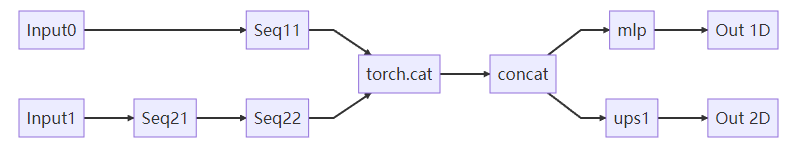

V0.2: ~Had 2 input and merge 2 outputs into 1~ | **<font color='red'>Not used!</font>**   
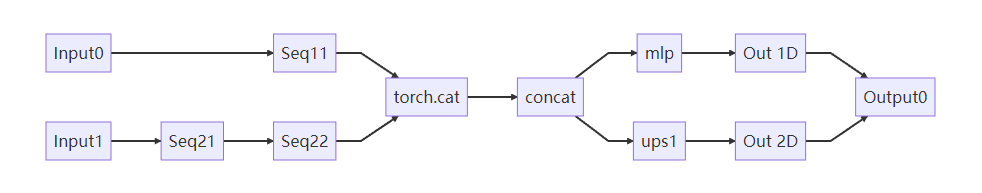

V0.3 Made model more complex and add some dropout and batchnorm  
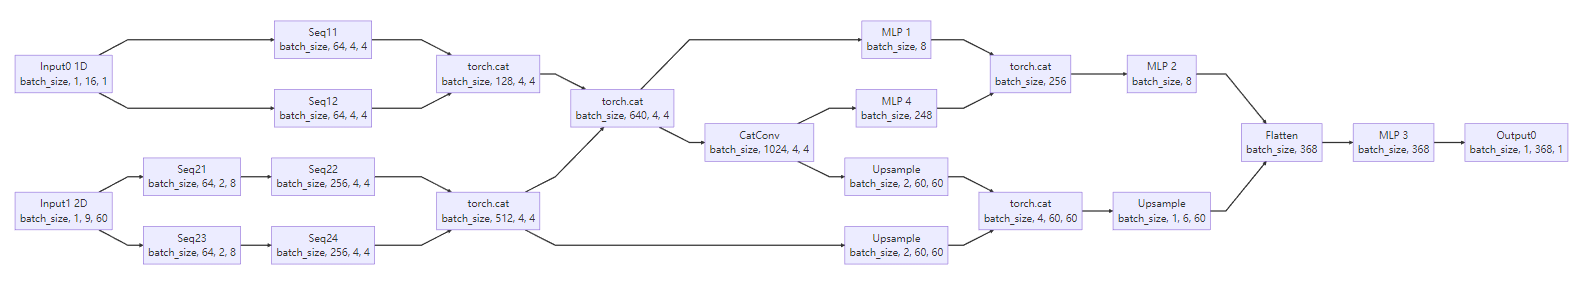

```mermaid
graph LR
input0[Input0 1D\nbatch_size, 1, 16, 1] 
input1[Input1 2D\nbatch_size, 1, 9, 60]
seq11[Seq11\nbatch_size, 64, 4, 4]
seq12[Seq12\nbatch_size, 64, 4, 4]
seq21[Seq21\nbatch_size, 64, 2, 8]
seq22[Seq22\nbatch_size, 256, 4, 4]
seq23[Seq23\nbatch_size, 64, 2, 8]
seq24[Seq24\nbatch_size, 256, 4, 4]
cat1[torch.cat\nbatch_size, 128, 4, 4]
cat2[torch.cat\nbatch_size, 640, 4, 4]
cat3[torch.cat\nbatch_size, 256]
cat4[torch.cat\nbatch_size, 512, 4, 4]
cat5[torch.cat\nbatch_size, 4, 60, 60]
mlp1[MLP 1\nbatch_size, 8]
mlp2[MLP 2\nbatch_size, 8]
mlp3[MLP 3\nbatch_size, 368]
mlp4[MLP 4\nbatch_size, 248]
flatten2[Flatten\nbatch_size, 368]
cat_conv[CatConv\nbatch_size, 1024, 4, 4]
ups1[Upsample\nbatch_size, 2, 60, 60]
ups2[Upsample\nbatch_size, 2, 60, 60]
ups3[Upsample\nbatch_size, 1, 6, 60]
output0[Output0\nbatch_size, 1, 368, 1]

input0 ---> seq11 ---> cat1 --> cat2 ---> mlp1 --> cat3 --> mlp2 --> flatten2
input0 ---> seq12 ---> cat1
input1 --> seq21 --> seq22 ---> cat4 --> cat2 --> cat_conv --> ups1 --> cat5 --> ups3 --> flatten2
input1 --> seq23 --> seq24 ---> cat4
cat4 --> ups2 -->cat5
cat_conv --> mlp4 --> cat3 
flatten2 --> mlp3 --> output0
```

Compared with the old version which didn't merge the 2 outputs, the new model is better for MSELoss and $R^2$ for calculating accuracies.

And the new model can train more quickly than the old one


In [194]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    if type(kernel_size) != tuple:
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = (torch.arange(kernel_size).reshape(-1, 1),
              torch.arange(kernel_size).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center) / factor) * \
               (1 - torch.abs(og[1] - center) / factor)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size, kernel_size))
        weight[range(in_channels), range(out_channels), :, :] = filt
    else:
        factor1 = (kernel_size[0] + 1) // 2
        factor2 = (kernel_size[1] + 1) // 2
        if kernel_size[0] % 2 == 1:
            center1 = factor1 - 1
        else:
            center1 = factor1 - 0.5
        if kernel_size[1] % 2 == 1:
            center2 = factor2 - 1
        else:
            center2 = factor2 - 0.5
        og = (torch.arange(kernel_size[0]).reshape(-1, 1),
              torch.arange(kernel_size[1]).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center1) / factor1) * \
               (1 - torch.abs(og[1] - center2) / factor2)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size[0], kernel_size[1]))
        weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

class TransConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size, stride=1, padding=0):
        super(TransConv, self).__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, 
                 kernel_size, stride, padding)
        self.trans_conv.weight.data.copy_(bilinear_kernel(in_channels, out_channels, kernel_size))
        
    def forward(self, x):
        return self.trans_conv(x)
    
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        out1d = x[0]
        out2d = x[1]
        out1d = out1d.flatten(1)
        out2d = out2d.flatten(1)
        out = torch.cat((out2d, out1d), 1)
        return out


class ConvDim1(nn.Module):
    def __init__(self):
        super(ConvDim1, self).__init__()
        self.seq1 = nn.Sequential( # 1, 16, 1
            nn.Conv2d(1, 16, 3, padding=(1, 2)), # 16, 16, 3
            nn.Conv2d(16, 32, 5, padding=(2, 3)), # 32, 16, 5
            nn.MaxPool2d((2,1)), # 32, 8, 5
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=(2, 4)),
            nn.MaxPool2d(2), 
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 64, 4, 4
        
        self.seq2 = nn.Sequential( # 1, 16, 1
            nn.Conv2d(1, 16, 3, padding=(1, 2)), # 16, 16, 3
            nn.Conv2d(16, 32, 5, padding=(2, 3)), # 32, 16, 5
            nn.MaxPool2d((2,1)), # 32, 8, 5
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=(2, 4)),
            nn.MaxPool2d(2), 
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 64, 4, 4
        
    def forward(self, x):
        x1 = self.seq1(x)
        x2 = self.seq2(x)
        x = torch.cat((x1, x2), axis = 1)
        return x
    
    
class ConvDim2(nn.Module):
    def __init__(self):
        super(ConvDim2, self).__init__()
        self.seq1_1 = nn.Sequential( # 1, 9, 60
            nn.Conv2d(1, 8, 5, padding=3),
            nn.Conv2d(8, 16, 5, padding=3),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=3),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 64, 2, 8
        self.seq1_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(2,3)),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=(2,2)),
            nn.MaxPool2d((1,2)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 256, 4, 4
        
        self.seq2_1 = nn.Sequential( # 1, 9, 60
            nn.Conv2d(1, 8, 5, padding=3),
            nn.Conv2d(8, 16, 5, padding=3),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=3),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 64, 2, 8
        self.seq2_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(2,3)),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=(2,2)),
            nn.MaxPool2d((1,2)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.Dropout2d(),
        ) # 256, 4, 4
        
        
    def forward(self, x):
        x1 = self.seq1_2(self.seq1_1(x))
        x2 = self.seq2_2(self.seq2_1(x))
        x = torch.cat((x1, x2), axis = 1)
        return x
    
    
class MLP(nn.Module):
    def __init__(self, layers, hidden_nodes = 144):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential()
        for i in range(layers):
            self.mlp.add_module(f'{i}', nn.Sequential(
                nn.LazyLinear(hidden_nodes),
                nn.ReLU(),
                nn.Dropout(),
            ))
        
    def forward(self, x):
        return self.mlp(x)
        return x

    
class Net(nn.Module):
    def __init__(self, out_size = 368,  mlp_node=144):
        super(Net, self).__init__()
        
        self.conv1 = ConvDim1()
        self.conv2 = ConvDim2()
        
        
        self.cat_conv = nn.Sequential(
            nn.Conv2d(640, 1024, 5, padding=4),
            nn.MaxPool2d(2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
        )
        
        self.ups1 = nn.Sequential(
            nn.Conv2d(1024, 2, 1),
            TransConv(2, 2, 32, padding=4, stride=12),
        )        
        self.ups2 = nn.Sequential(
            nn.Conv2d(512, 2, 1),
            TransConv(2, 2, 32, padding=4, stride=12),
        )        
        self.ups3 = nn.Sequential(
            nn.Conv2d(4, 64, 36, 8, 8),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 1, 1),
            TransConv(1, 1, (4, 36), padding=(1,8), stride=(2,20)),
        )
        
        self.mlp1 = nn.Sequential(
            nn.Flatten(),
            MLP(3),
            nn.LazyLinear(8),
        )
        self.mlp2 = nn.Sequential(
            MLP(3),
            nn.LazyLinear(8),
        )
        self.mlp3 = nn.Sequential(
            MLP(3),
            nn.LazyLinear(out_size),
        )
        self.mlp4 = nn.Sequential(
            nn.Flatten(),
            MLP(3),
            nn.LazyLinear(248),
        )
        
        self.flatten = Flatten()
        
    
    def forward(self, x):
        t1d, t2d = x[0], x[1]
        t1d = self.conv1(t1d)
        t2d = self.conv2(t2d)
        tout = torch.cat((t1d, t2d), axis = 1)
        tconv = self.cat_conv(tout)
        tmlp1 = self.mlp1(tout)
        tcmlp4 = self.mlp4(tconv)
        tcat = torch.cat((tmlp1, tcmlp4), axis=1)
        tcat = self.mlp2(tcat)
        ccu = self.ups1(tconv)
        cu = self.ups2(t2d)
        cucat = torch.cat((ccu, cu), axis = 1)
        cucat = self.ups3(cucat)
        flt = self.flatten((cucat, tcat))
        out = self.mlp3(flt)
        out = torch.unsqueeze(out, 1)
        out = torch.unsqueeze(out, 3)
        return out
    


In [195]:
net = Net()
# weights = torch.load('/kaggle/input/atmospred/pytorch/tttt/1/best (2).pth', map_location=device)
# net.load_state_dict(weights)

In [196]:
ttensor = [torch.rand(5, 1, 16, 1), torch.rand(5, 1, 9, 60)]
# print(net(ttensor).shape)
# del(ttensor) # 清理
res = net(ttensor)
res.shape

torch.Size([5, 1, 368, 1])

In [55]:
import torch.optim as optim

# def criterion(pred, target):
#     loss1 = torch.mean((pred[0] - target[0])**2)
#     loss2 = torch.mean((pred[1] - target[1])**2)
#     loss = loss1 + loss2
#     return loss

criterion = nn.MSELoss()
    
optimizer = optim.Adam(net.parameters(), lr=lr)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def graph(acc, loss, title):
    """ 绘制准确率和损失曲线

    Args:
        acc (list): [train, val]/[test]
        loss (list): [train, val]/[test]
        title (str): Title
    """
    assert len(acc) == len(loss), 'Length of acc and loss must be the same'
    global save_run_dir
    if len(acc) == 2:
        plt.subplot(1, 2, 1)
        plt.plot(acc[0], label='Training Accuracy')
        plt.plot(acc[1], label='Validation Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(loss[0], label='Training Loss')
        plt.plot(loss[1], label='Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    elif len(acc) == 1:
        plt.subplot(2, 1, 1)
        plt.plot(acc[0], label='Test Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(loss[0], label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

In [32]:
def r2accu(pred, targ):
    residual_err = pred - targ
    err_sq = residual_err ** 2
    ss_res = torch.sum(err_sq)
    ss_tot = torch.sum(pred ** 2 + targ ** 2)
    r_2 = 1 - (ss_res / ss_tot)
    return r_2.item()

ts1, ts2 = torch.tensor((1,2,3,4)), torch.tensor((2,2,3,4))
print(ts1, ts2, r2accu(ts1, ts2))

del(ts1)
del(ts2)

tensor([1, 2, 3, 4]) tensor([2, 2, 3, 4]) 0.9841269850730896


In [56]:
lowest_loss = float('inf')

accus, losses = [[],[]], [[],[]]
epoch = 0
last_epoch = 0

In [ ]:
net = net.cuda(device)
for idx, chunk in enumerate(train_chunks):
    patience = 0
    timer.start(f'Train {num_epochs} epochs on chunk {idx}')
    train_loader, val_loader = get_chunk_loader(chunk)
    while epoch < num_epochs:
        epoch += 1
        t0 = time.time()
        net.train()
        train_loss = 0.0
        train_accu = 0.0
        num_train_batches = 0

        for inp, outp in tqdm(train_loader):
#             inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.to(device)
            inp, outp = [inps.cuda(device, non_blocking = True) for inps in inp], outp.cuda(device, non_blocking = True)
            out_h = net(inp)
            crit = criterion(out_h, outp)
            loss = crit.item()
            train_loss += loss
            accu = r2accu(out_h, outp)
            train_accu += accu
            crit.backward()
            optimizer.step()
            optimizer.zero_grad()
            num_train_batches += 1
        avg_train_loss = train_loss / num_train_batches
        losses[0].append(avg_train_loss)
        avg_train_accu = train_accu / num_train_batches
        accus[0].append(avg_train_accu)

        net.eval()
        val_loss = 0.0
        val_accu = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for inp, outp in tqdm(val_loader):
#                 inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.cuda()
                inp, outp = [inps.cuda(device, non_blocking = True) for inps in inp], outp.cuda(device, non_blocking = True)
                out_h = net(inp)
                crit = criterion(out_h, outp)
                val_loss += crit.item()
                accu = r2accu(out_h, outp)
                val_accu += accu
                num_val_batches += 1
        try:
            last_val_loss = avg_val_loss
        except:
            last_val_loss = lowest_loss
        avg_val_loss = val_loss / num_val_batches
        losses[1].append(avg_val_loss)
        avg_val_accu = val_accu / num_val_batches
        accus[1].append(avg_val_accu)

        if avg_val_loss < lowest_loss:
            torch.save(net.state_dict(), 'best.pth')  # 保存模型参数而不是整个模型
            lowest_loss = avg_val_loss

        t1 = time.time()
        print(f'Chunk {idx} | Epoch {epoch - last_epoch}/{epoch} > Time Cost: {t1-t0:.2f}s | patience: {patience} \n\t', 
              f'Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}\n\t',
              f'Train Accu: {avg_train_accu:.3f} | Val Accu: {avg_val_accu:.3f}')
        if avg_train_loss < avg_val_loss and last_val_loss < avg_val_loss:
            patience += 1
#         else:
#             patience = 0
        if patience >= max_patience:
            print(f'{max_patience} epochs had val loss bigger than train loss. Exit for next chunk of data')
            patience = 0
            last_epoch = epoch
            del(chunk)
            break
    timer.stop()
torch.save(net.state_dict(), "latest.pth") 
graph(accus, losses, 'Train')

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train_in.shape = (80000, 556)
train_out.shape = (80000, 368)
val_in.shape = (20000, 556)
val_out.shape = (20000, 368)
len(train_dataset) = 80000
len(val_dataset) = 20000
0 Load datasets... Time Cost: 0.210s


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]


Chunk 0 | Epoch 2 > Time Cost: 131.92s 
	 Train Loss: 320.777 | Val Loss: 211.261
	 Train Accu: 0.728 | Val Accu: 0.787


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Chunk 0 | Epoch 3 > Time Cost: 135.26s 
	 Train Loss: 60.331 | Val Loss: 40.725
	 Train Accu: 0.953 | Val Accu: 0.971


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]


Chunk 0 | Epoch 4 > Time Cost: 128.96s 
	 Train Loss: 33.712 | Val Loss: 33.943
	 Train Accu: 0.975 | Val Accu: 0.974


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]


Chunk 0 | Epoch 5 > Time Cost: 129.18s 
	 Train Loss: 27.571 | Val Loss: 38.835
	 Train Accu: 0.980 | Val Accu: 0.974


100%|██████████| 56/56 [00:32<00:00,  1.73it/s]


Chunk 0 | Epoch 6 > Time Cost: 130.52s 
	 Train Loss: 24.983 | Val Loss: 27.269
	 Train Accu: 0.982 | Val Accu: 0.980


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Chunk 0 | Epoch 7 > Time Cost: 129.73s 
	 Train Loss: 21.781 | Val Loss: 25.032
	 Train Accu: 0.984 | Val Accu: 0.981


100%|██████████| 56/56 [00:32<00:00,  1.74it/s]


Chunk 0 | Epoch 8 > Time Cost: 130.09s 
	 Train Loss: 19.501 | Val Loss: 22.538
	 Train Accu: 0.986 | Val Accu: 0.983


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Chunk 0 | Epoch 9 > Time Cost: 129.62s 
	 Train Loss: 16.973 | Val Loss: 20.772
	 Train Accu: 0.988 | Val Accu: 0.985


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]


Chunk 0 | Epoch 10 > Time Cost: 129.83s 
	 Train Loss: 15.057 | Val Loss: 20.825
	 Train Accu: 0.989 | Val Accu: 0.985


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]


Chunk 0 | Epoch 11 > Time Cost: 128.87s 
	 Train Loss: 14.483 | Val Loss: 18.949
	 Train Accu: 0.989 | Val Accu: 0.986


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]


Chunk 0 | Epoch 12 > Time Cost: 129.01s 
	 Train Loss: 13.554 | Val Loss: 18.580
	 Train Accu: 0.990 | Val Accu: 0.987


100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


Chunk 0 | Epoch 13 > Time Cost: 128.44s 
	 Train Loss: 13.145 | Val Loss: 18.390
	 Train Accu: 0.990 | Val Accu: 0.987


100%|██████████| 56/56 [00:32<00:00,  1.74it/s]


Chunk 0 | Epoch 14 > Time Cost: 129.17s 
	 Train Loss: 12.440 | Val Loss: 19.162
	 Train Accu: 0.991 | Val Accu: 0.986
3 epochs had val loss bigger than train loss. Exit for next chunk of data
7 Train 100 epochs on chunk 0 Time Cost: 1690.810s


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train_in.shape = (80000, 556)
train_out.shape = (80000, 368)
val_in.shape = (20000, 556)
val_out.shape = (20000, 368)
len(train_dataset) = 80000
len(val_dataset) = 20000
0 Load datasets... Time Cost: 0.211s


100%|██████████| 56/56 [00:32<00:00,  1.73it/s]


Chunk 1 | Epoch 15 > Time Cost: 130.13s 
	 Train Loss: 20.366 | Val Loss: 23.475
	 Train Accu: 0.985 | Val Accu: 0.983


100%|██████████| 56/56 [00:32<00:00,  1.73it/s]


Chunk 1 | Epoch 16 > Time Cost: 131.55s 
	 Train Loss: 16.026 | Val Loss: 22.338
	 Train Accu: 0.988 | Val Accu: 0.984


100%|██████████| 56/56 [00:32<00:00,  1.72it/s]


Chunk 1 | Epoch 17 > Time Cost: 131.24s 
	 Train Loss: 14.456 | Val Loss: 28.031
	 Train Accu: 0.990 | Val Accu: 0.978


100%|██████████| 56/56 [00:32<00:00,  1.73it/s]


Chunk 1 | Epoch 18 > Time Cost: 130.65s 
	 Train Loss: 13.731 | Val Loss: 30.792
	 Train Accu: 0.990 | Val Accu: 0.977
3 epochs had val loss bigger than train loss. Exit for next chunk of data
8 Train 100 epochs on chunk 1 Time Cost: 523.776s


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train_in.shape = (80000, 556)
train_out.shape = (80000, 368)
val_in.shape = (20000, 556)
val_out.shape = (20000, 368)
len(train_dataset) = 80000
len(val_dataset) = 20000
0 Load datasets... Time Cost: 0.223s


100%|██████████| 56/56 [00:31<00:00,  1.79it/s]


Chunk 2 | Epoch 19 > Time Cost: 130.45s 
	 Train Loss: 22.177 | Val Loss: 25.378
	 Train Accu: 0.984 | Val Accu: 0.982


100%|██████████| 56/56 [00:43<00:00,  1.29it/s]


Chunk 2 | Epoch 20 > Time Cost: 141.45s 
	 Train Loss: 18.045 | Val Loss: 23.479
	 Train Accu: 0.987 | Val Accu: 0.983


100%|██████████| 56/56 [00:32<00:00,  1.73it/s]


Chunk 2 | Epoch 21 > Time Cost: 131.19s 
	 Train Loss: 15.768 | Val Loss: 23.987
	 Train Accu: 0.989 | Val Accu: 0.983


100%|██████████| 56/56 [00:32<00:00,  1.75it/s]


Chunk 2 | Epoch 22 > Time Cost: 130.03s 
	 Train Loss: 14.237 | Val Loss: 26.083
	 Train Accu: 0.990 | Val Accu: 0.983


100%|██████████| 56/56 [00:32<00:00,  1.75it/s]


Chunk 2 | Epoch 23 > Time Cost: 130.79s 
	 Train Loss: 12.933 | Val Loss: 24.041
	 Train Accu: 0.991 | Val Accu: 0.983


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]


Chunk 2 | Epoch 24 > Time Cost: 130.54s 
	 Train Loss: 12.191 | Val Loss: 22.121
	 Train Accu: 0.991 | Val Accu: 0.984


100%|██████████| 56/56 [00:31<00:00,  1.80it/s]


Chunk 2 | Epoch 25 > Time Cost: 128.91s 
	 Train Loss: 11.076 | Val Loss: 22.781
	 Train Accu: 0.992 | Val Accu: 0.983
3 epochs had val loss bigger than train loss. Exit for next chunk of data
9 Train 100 epochs on chunk 2 Time Cost: 923.596s


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 256 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train_in.shape = (80000, 556)
train_out.shape = (80000, 368)
val_in.shape = (20000, 556)
val_out.shape = (20000, 368)
len(train_dataset) = 80000
len(val_dataset) = 20000
0 Load datasets... Time Cost: 0.216s


  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
# 清理
del(inp)
del(outp)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)


# Test Model

In [ ]:
try:
    del(net)
    print('Latest net released!')
except:
    print('No model trained')

In [ ]:
net = Net().to(device)
# net.load_state_dict(torch.load('/kaggle/input/atmospred/pytorch/trained.pth/1/20240502-001.pth', map_location=device))
net.load_state_dict(torch.load('best.pth', map_location=device))
print('Load best model.')

In [ ]:
test_dataset = MyDataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(test_dataset) = }')

In [ ]:
timer.start('Run Test')
net.eval()
test_loss = 0.0
test_accu = 0.0
num_test_batches = 0

with torch.no_grad():
    for i, (inp, outp) in enumerate(tqdm(test_loader)):
        inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.to(device)
        out_h = net(inp)
        crit = criterion(out_h, outp)
        test_loss += crit.item()
        test_accu += r2accu(out_h, outp)
        num_test_batches += 1

avg_test_loss = test_loss / num_test_batches
avg_test_accu = test_accu / num_test_batches

print(f'Test Loss: {avg_test_loss:.3f} | Test Accu: {avg_test_accu:.3f}')
timer.stop()

In [ ]:
# 清理变量
del(test_dataset)
del(test_loader)
del(out_h)
del(inp, outp)

# Read test input data

I didn't learn about Polars, but i heard it faster than pandas. So in this part I want to try polars instead of pandas. 

If everything goes well, i may switch the former pandas operations to polars. 

In [ ]:
import polars as pl

timer.start('Read test csv dataset and submission sample')
subm_set = pl.read_csv(test_csv)
subm_multip = pl.read_csv(subm_spl)
timer.stop()
sample_cols = subm_multip.columns

In [ ]:
subm_multip.head(2)

In [ ]:
insts = subm_set[subm_set.columns[0]]
subm_in = subm_set[subm_set.columns[1:]]
subm_in.shape

In [ ]:
class TestDataset(Dataset):
    def __init__(self, dsin, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.row(x))
        din = [in1[1], in2[1]]
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
        din = [tensor.to(torch.float32) for tensor in din]
        
        return din

In [ ]:
subm_dataset = TestDataset(subm_in)
subm_dataset[0][0].shape, subm_dataset[0][1].shape

# Process the output

- write a function to multiply predictions with sample data
- save file

In [ ]:
# out_df = subm_multip[subm_multip.columns[1:]]
subm_multip = subm_multip.to_numpy()
subm_multip.shape, subm_multip[:, 0]

In [ ]:
out_df = subm_multip[:, 1:].astype(float)
out_df = torch.tensor(out_df).to(device).to(torch.float32)
out_df.shape, out_df[1:4, 2:4]

In [ ]:
def convert_output(pred):
    """将输出张量转换为 dataframe 的 n 行"""
    pred = pred.squeeze(3).squeeze(1)
    return pred

def postprocess(pred, scaler):
    pred = convert_output(pred)
    scaler *= pred
    return scaler

In [ ]:
subm_batch_size = batch_size

In [ ]:
subm_loader = DataLoader(subm_dataset, batch_size = subm_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
result = None
data_len = len(subm_loader)
print(f'Submission data lenth {data_len}')

In [ ]:
timer.start('Get outputs')
with torch.no_grad():
    for i, smp in enumerate(subm_loader):
        t0 = time.time()
        smp =  [smps.to(device, non_blocking=True) for smps in smp]
        scaler = out_df[i*subm_batch_size:(i+1)*subm_batch_size, :]
        pred = net(smp)
        scaler = postprocess(pred, scaler)
        if i == 0:
            result = scaler
        else:
            result = torch.cat((result, scaler), axis=0)
        print(f'[{"=" * int(25 * i / data_len)}{"C" if i % 2 == 0 else "c"}{"-" * (25 - int(25 * i / data_len))}] Batch {i}/{data_len} > {result.shape = } | {1 / (time.time() - t0):.2f}it/s\r', end='')
    print('\n')
print(f'Batch {i} > {result.shape = } | ')
timer.stop()

In [ ]:
result = result.to('cpu').detach().numpy()
result.shape, result.dtype

In [ ]:
sample_ids = pl.from_numpy(subm_multip[:, 0].reshape(-1 ,1))
sample_ids.columns = sample_cols[0:1]
sample_prs = pl.from_numpy(result)
sample_prs.columns = sample_cols[1:]
sample_ids.head(2), sample_prs.head(2)

In [ ]:
# save_data = pl.from_numpy(data)
save_save = pl.concat([sample_ids, sample_prs], how = "horizontal")
save_save.head(2)

In [ ]:
save_save.write_csv(out_csv)